In [2]:
import os
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math as mt
from scipy.stats import norm
from scipy.special import erf

log  = np.log
exp  = np.exp
sqrt = np.sqrt
pi   = mt.pi

## Plotting functions

In [3]:
def findBoundary(data, howClose = 0.1):
    "Picks out rows corresponding to values"
    "when detection boundary is just reached."
    
    level = data['level'].iloc[0]
    
#     df = data.loc[(data['error1'] <= level+eps) & (data['error1'] >= level-eps)]
    df = data.loc[(data['error2'] < (1+howClose/2)*level) & (data['error2'] > (1-howClose/2)*level)]
    
    return df 

def fitLineOnDataFrame(df, variable, logged = False):
    if (logged):
        logx = np.log(df[variable])
        logy = np.log(df['d'])
        coeffs = np.polyfit(logx, logy, deg=1)
        poly = np.poly1d(coeffs)

        yFit = lambda x: np.exp(poly(np.log(x)))
    else:
        x = df[variable]
        y = df['d']
        coeffs = np.polyfit(x, y, deg=1)
        poly = np.poly1d(coeffs)

        yFit = lambda x: poly(x)
    
    print(coeffs)
    
    plt.plot(df[variable], yFit(df[variable]))
    plt.plot(df[variable], df['d'], 'bo')
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

## Import data from different notebook

In [4]:
%store -r trainData
%store -r trainLabels

%store -r testData
%store -r testLabels

%store -r t
%store -r n
%store -r nmax

print(len(trainData))

44154


# 2 dimensions

Only run once! If run again, then restart

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 2
epochs = 7

# input image dimensions
img_rows, img_cols = nmax, nmax

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = trainData
y_train = trainLabels

print(x_train.shape)

x_test = testData
y_test = testLabels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(44154, 50, 50)
x_train shape: (44154, 50, 50, 1)
44154 train samples
8474 test samples
Epoch 1/7
345/345 [==============================] - 4s 12ms/step - loss: 0.6620 - accuracy: 0.5655 - val_loss: 0.4984 - val_accuracy: 0.7494
Epoch 2/7
345/345 [==============================] - 4s 11ms/step - loss: 0.4650 - accuracy: 0.7865 - val_loss: 0.4092 - val_accuracy: 0.8259
Epoch 3/7
345/345 [==============================] - 4s 12ms/step - loss: 0.4191 - accuracy: 0.8120 - val_loss: 0.3925 - val_accuracy: 0.8261
Epoch 4/7
345/345 [==============================] - 4s 12ms/step - loss: 0.4053 - accuracy: 0.8204 - val_loss: 0.3804 - val_accuracy: 0.8256
Epoch 5/7
345/345 [==============================] - 4s 12ms/step - loss: 0.3968 - accuracy: 0.8203 - val_loss: 0.3912 - val_accuracy: 0.8207
Epoch 6/7
345/345 [==============================] - 4s 12ms/step - loss: 0.3876 - accuracy: 0.8255 - val_loss: 0.3754 - val_accuracy: 0.8320
Epoch 7/7
345/345 [==============================] - 4s 12ms

## Find resolution using the model trained above

In [8]:
def calculateProbs2d(n = 50, dist = 0, sd = 0.08, whichProb = "hyp"):
    x0 = 0.5
    y0 = 0.5
    
    y1 = y0
    y2 = y0
    
    x1 = x0 - dist/2
    x2 = x0 + dist/2
    
    probs = {} # this is much faster here
#     probs = np.zeros((nmax,nmax),dtype=np.float32)
    
    if (whichProb == "hyp"):
        for i in range(1, n+1):
            for j in range(1, n+1):
                probs[i-1,j-1] = 0.25  * ( erf( (i - n*x0) / (sqrt(2)*n*sd) ) \
                                       - erf( (-1 + i - n*x0)/(sqrt(2)*n*sd) ) )\
                                   * ( erf( (j - n*y0) / (sqrt(2)*n*sd) ) \
                                       - erf( (-1 + j - n*y0)/(sqrt(2)*n*sd) ) )
    else:
        for i in range(1, n+1):
            for j in range(1, n+1):
                probs[i-1,j-1] = 0.5*0.25 * (
                       ( erf( (i - n*x1) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x1)/(sqrt(2)*n*sd) ) )
                     * ( erf( (j - n*y1) / (sqrt(2)*n*sd) ) - erf( (-1 + j - n*y1)/(sqrt(2)*n*sd) ) )
                   +   
                       ( erf( (i - n*x2) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x2)/(sqrt(2)*n*sd) ) )
                     * ( erf( (j - n*y2) / (sqrt(2)*n*sd) ) - erf( (-1 + j - n*y2)/(sqrt(2)*n*sd) ) )
                       )
                    
    return probs


def generateData2d(model, t, n, nmax, probs, mySeed):
    np.random.seed(mySeed)
    Y0 = np.zeros((nmax,nmax),dtype=np.float32) # this is same here
#     Y0 = {}
    
    for i in range(n):
        for j in range(n):
            if (model == "gauss"):
                Y0[i,j] = np.random.normal(t*probs[i,j], 1)
            elif (model == "gaussEquivPoi"):
                Y0[i,j] = np.random.normal(2*sqrt(t*probs[i,j]), 1)
            elif (model == "poisson"):
                Y0[i,j] =  np.random.poisson(t*probs[i,j])
            elif (model == "binomial"):
                Y0[i,j] =  np.random.binomial(t, probs[i,j])

    for i in range(nmax-n):
        for j in range(nmax-n):
            Y0[n+i,n+j] = 0

    return Y0

def findDetectionBoundary(model, noiseModel, t, n, reps, level, nmax, seed):
    
    upperBound = 1.05*level
    lowerBound = 0.95*level
        
    output = []
    # CHANGED THIS!
    aboveUpperB = False
    d = 0.09
    
    for fwhm in np.arange(0.15, 0.25001, 0.01):
#         for t in range():
#             for n in range():
            
            data = []
            checkedDists = []
            error2 = 10
            
            # set the stepSize back
            stepSize = -1
            
            # assuming linear relationship to fwhm
            # advance distance by one step
            d += 0.01

            while error2 < lowerBound or error2 > upperBound:
            #                 probs = calculateProbs(n, d, fwhm/2*sqrt(2*log(2)), "alt")

                probs = calculateProbs2d(n, d, fwhm/(2*sqrt(2*log(2))), "alt")

                for rep in range(reps):
                    data.append( generateData2d(noiseModel, t, n, nmax, \
                                probs, seed + rep)/t )
                
        
                
                x_test = np.array(data, ndmin=2)
        
                img_rows, img_cols = nmax, nmax

                if K.image_data_format() == 'channels_first':
                    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
                    input_shape = (1, img_rows, img_cols)
                else:
                    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
                    input_shape = (img_rows, img_cols, 1)

                x_test = x_test.astype('float32')
                
                y_test = np.repeat(1, reps)
                
                y_test = keras.utils.to_categorical(y_test, 2)
                
                score = model.evaluate(x_test, y_test, verbose=0)
#                 print('Test accuracy:', score[1])
                
                error2 = 1-score[1]
                
                data = []
                
                output.append([t, n, fwhm, d, level, reps, error2])
                print(f'{fwhm:.2f}', f'{d:.6f}', f'{error2:.4f}')
                
                checkedDists.append(d)
                if len(checkedDists) > 10:
                    print("not converged")
                    break
                    
                aboveUpperBOld = aboveUpperB
                
                if   error2 > upperBound:
                    aboveUpperB = True
                elif error2 < lowerBound:
                    aboveUpperB = False
                else:
                    break
                
                if aboveUpperBOld != aboveUpperB:
                    stepSize += 1
                
                if aboveUpperB:
                    d += 0.01/2**stepSize
                else:
                    d -= 0.01/2**stepSize
                
                if d in checkedDists or d < 0:
                    # go one step back and take half the previous step
                    if (aboveUpperB):
                        d -= 0.01/2**stepSize 
                        d += 0.01/2**(stepSize+1)
                    else:
                        d += 0.01/2**stepSize 
                        d -= 0.01/2**(stepSize+1)
                    stepSize += 1
        
    return output

### $d$ vs $fwhm$

In [9]:
seed  = 10**7
level = 0.1
t     = 500
n     = 50
output = findDetectionBoundary(model, "poisson", t, n, 1000, level, nmax, seed)
df = pd.DataFrame(data=output,
                  columns=['t', 'n', 'fwhm', 'd', 'level', 'reps', 'error2'])

0.15 0.100000 0.0000
0.15 0.080000 0.0000
0.15 0.060000 0.1160
0.15 0.070000 0.0240
0.15 0.065000 0.0540
0.15 0.060000 0.1160
0.15 0.062500 0.0820
0.15 0.061250 0.0960
0.16 0.071250 0.0370
0.16 0.051250 0.2880
0.16 0.061250 0.1090
0.16 0.066250 0.0640
0.16 0.063750 0.0810
0.16 0.061250 0.1090
0.16 0.062500 0.0910
0.16 0.061875 0.0970
0.17 0.071875 0.0420
0.17 0.051875 0.3300
0.17 0.061875 0.1590
0.17 0.066875 0.0790
0.17 0.064375 0.1080
0.17 0.065625 0.0840
0.17 0.065000 0.1020
0.18 0.075000 0.0500
0.18 0.055000 0.2660
0.18 0.065000 0.1520
0.18 0.075000 0.0500
0.18 0.070000 0.0930
0.18 0.065000 0.1520
0.18 0.067500 0.1150
0.18 0.068750 0.1000
0.19 0.078750 0.0440
0.19 0.068750 0.1340
0.19 0.073750 0.0800
0.19 0.071250 0.1080
0.19 0.072500 0.0940
0.19 0.071875 0.0990
0.20 0.081875 0.0520
0.20 0.061875 0.2750
0.20 0.071875 0.1430
0.20 0.081875 0.0520
0.20 0.076875 0.0940
0.20 0.071875 0.1430
0.20 0.074375 0.1180
0.20 0.075625 0.1050
0.20 0.076250 0.0960
0.21 0.086250 0.0550
0.21 0.076250

[0.30284091 0.01465909]


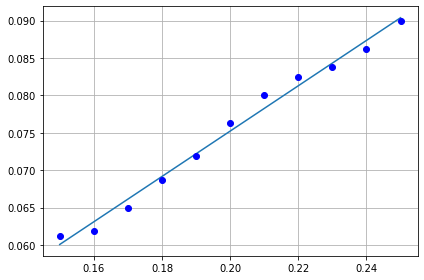

In [10]:
fitLineOnDataFrame(findBoundary(df, level), 'fwhm', logged=False)

## the dependence of resolution $d$ on FWHM is not quite linear when using the above CNN, but to the power of 0.8

[ 0.80323094 -1.29258658]


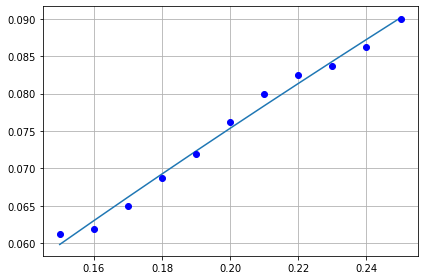

In [11]:
fitLineOnDataFrame(findBoundary(df, level), 'fwhm', logged=True)